In [ ]:
!cp '/content/drive/MyDrive/VU Amsterdam/Year 3/Machine Learning/MLProject/src/data.zip' .
!unzip data.zip

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt
from keras import backend as K

     |████████████████████████████████| 133 kB 14.6 MB/s 


In [ ]:
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from numba import cuda

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
def getData():

    dir = 'data/'

    df = pd.read_csv(dir + 'labels.csv')

    df['path'] = df['path'].str.replace('\\', os.sep)

    return df

In [ ]:
df = getData()

train_df = df.loc[(df['is_validation'] == 0) & (df['is_final_validation'] == 0)]
valid_df =df.loc[df['is_validation'] == 1]
test_df = df.loc[df['is_final_validation'] == 1 ]

train_cleaned_df = pd.concat( [train_df.loc[train_df['is_bee'] == 1], train_df.loc[train_df['is_wasp'] == 1] ])
valid_cleaned_df = pd.concat( [valid_df.loc[valid_df['is_bee'] == 1], valid_df.loc[valid_df['is_wasp'] == 1] ])

gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train = gen.flow_from_dataframe(train_cleaned_df, directory= 'data/', x_col='path', y_col='label', target_size=(256,256), class_mode="binary")
valid = gen.flow_from_dataframe(valid_cleaned_df, directory= 'data/', x_col='path', y_col='label', target_size=(256,256), class_mode="binary")


Found 5635 validated image filenames belonging to 2 classes.
Found 1234 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


In [ ]:
def model_builder(hp):
  K.clear_session()

  model = Sequential()

  hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
  model.add(Dense(units=hp_units, input_shape=(256,256,3), activation='relu'))

  hp_dropout = hp.Float('rate', min_value=0.0, max_value=0.5, step=0.1)
  model.add(Dropout(hp_dropout))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=hp_learning_rate)
  
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
!rm -R tuner

rm: cannot remove 'tuner': No such file or directory


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='tuner',
                     project_name='ML Project ANN')

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", patience = 5)

tuner.search(train, epochs=25, batch_size=16, validation_data=valid, callbacks=[earlystopping])

Trial 30 Complete [00h 03m 37s]
val_accuracy: 0.8241491317749023

Best val_accuracy So Far: 0.835494339466095
Total elapsed time: 01h 14m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
tuner.results_summary()

In [ ]:
tuner.get_best_hyperparameters()[0].values


{'learning_rate': 0.001,
 'rate': 0.0,
 'tuner/bracket': 2,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 2,
 'tuner/trial_id': '0014',
 'units': 128}

In [ ]:
tuner.get_best_models()[0].summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 256, 128)     512       
                                                                 
 dropout (Dropout)           (None, 256, 256, 128)     0         
                                                                 
 flatten (Flatten)           (None, 8388608)           0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8388609   
                                                                 
Total params: 8,389,121
Trainable params: 8,389,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train, batch_size=32, epochs=50, validation_data=valid)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
177/177 [==============================] - 29s 162ms/step - loss: 9.0235 - accuracy: 0.7168 - val_loss: 1.2597 - val_accuracy: 0.8266
Epoch 2/50
177/177 [==============================] - 29s 162ms/step - loss: 0.9818 - accuracy: 0.8041 - val_loss: 0.9036 - val_accuracy: 0.7974
Epoch 3/50
177/177 [==============================] - 28s 158ms/step - loss: 0.4749 - accuracy: 0.8543 - val_loss: 0.6412 - val_accuracy: 0.8339
Epoch 4/50
177/177 [==============================] - 28s 157ms/step - loss: 0.3016 - accuracy: 0.8978 - val_loss: 0.6385 - val_accuracy: 0.8063
Epoch 5/50
177/177 [==============================] - 28s 156ms/step - loss: 0.2567 - accuracy: 0.9075 - val_loss: 0.7340 - val_accuracy: 0.8144
Epoch 6/50
177/177 [==============================] - 28s 157ms/step - loss: 0.2196 - accuracy: 0.9219 - val_loss: 0.7316 - val_accuracy: 0.8331
Epoch 7/50
177/177 [==============================] - 28s 157ms/step - loss: 0.2244 - accuracy: 0.9301 - val_loss: 0.6377 - val_ac

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
final_h = hypermodel.fit(train, batch_size=32, epochs=best_epoch, validation_data=valid)

Epoch 1/3
177/177 [==============================] - 29s 159ms/step - loss: 6.0188 - accuracy: 0.7274 - val_loss: 1.8069 - val_accuracy: 0.5940
Epoch 2/3
177/177 [==============================] - 28s 158ms/step - loss: 0.7034 - accuracy: 0.8192 - val_loss: 0.7655 - val_accuracy: 0.8063
Epoch 3/3
177/177 [==============================] - 28s 157ms/step - loss: 0.4075 - accuracy: 0.8674 - val_loss: 0.6478 - val_accuracy: 0.8306


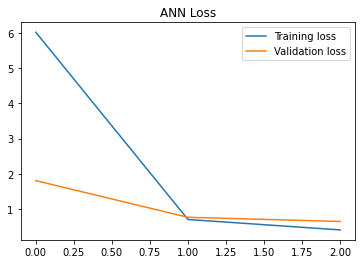

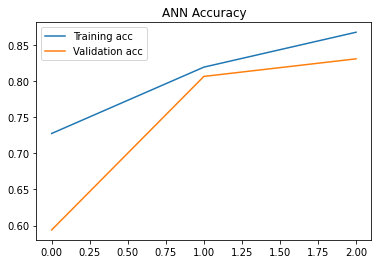

In [ ]:
plt.title('ANN Loss')
plt.plot(final_h.epoch, final_h.history['loss'], label='Training loss')
plt.plot(final_h.epoch, final_h.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

plt.title('ANN Accuracy')
plt.plot(final_h.epoch, final_h.history['accuracy'], label='Training acc')
plt.plot(final_h.epoch, final_h.history['val_accuracy'], label='Validation acc')
plt.legend()
plt.show()


In [ ]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 256, 128)     512       
                                                                 
 dropout (Dropout)           (None, 256, 256, 128)     0         
                                                                 
 flatten (Flatten)           (None, 8388608)           0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8388609   
                                                                 
Total params: 8,389,121
Trainable params: 8,389,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hypermodel.save('hp_ann_model')  # save the model
!zip -r hp_ann_model.zip hp_ann_model

INFO:tensorflow:Assets written to: hp_ann_model/assets


INFO:tensorflow:Assets written to: hp_ann_model/assets


  adding: hp_ann_model/ (stored 0%)
  adding: hp_ann_model/assets/ (stored 0%)
  adding: hp_ann_model/saved_model.pb (deflated 87%)
  adding: hp_ann_model/variables/ (stored 0%)
  adding: hp_ann_model/variables/variables.index (deflated 59%)
  adding: hp_ann_model/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: hp_ann_model/keras_metadata.pb (deflated 85%)
